# Group19 CS5344 Project - Tree based modelling code

In [1]:
# data manipulation
import pandas as pd
import numpy as np
from re import sub

from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy.stats import uniform, randint, zscore

from xgboost import XGBRegressor

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# data preprocessing
from sklearn.preprocessing import LabelEncoder
# import missingno as msno

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



# feature importance
from xgboost import plot_importance as xgboost_plot_importance
from lightgbm import plot_importance as lightgbm_plot_importance

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# mean_absolute_percentage_error pre defined function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [2]:
import pandas as pd
# please load "Full_Dataset.csv" in the working directory file
com = pd.read_csv("Full_Dataset.csv")
com["date"] = pd.to_datetime(com["date"])
com.rename(columns={"GME_y": "GME", "TSLA_y": "TSLA", "SPY_y": "SPY", "^IXIC_y": "IXIC", "DJIA_y": "DJIA"},inplace = True)

com.shape

(755, 43)

In [3]:
tar = ["GME","TSLA","SPY","IXIC","DJIA"]
for i in tar:
    com [i] = com[i].round(2)

In [4]:
# finding dateno, year and month
com["dateNo"] = com["date"].dt.day
com["yr"] = com["date"].dt.year
com["month"] = com["date"].dt.month
com.sort_values(by='date', ascending=True ,inplace=True)
com.drop(columns=['date'],inplace=True)
com.shape

(755, 45)

In [5]:
# training columns
train_col_wod = ["score","sentiment_score","bull_scores","bear_scores","num_comments","num_crossposts",
                 "wallstreetbets_author_cnt","SecurityAnalysis_author_cnt","investing_author_cnt","stocks_author_cnt",
                 "RobinHood_author_cnt","wallstreetbets_id_cnt","SecurityAnalysis_id_cnt","investing_id_cnt","stocks_id_cnt",
                 "RobinHood_id_cnt","wallstreetbets_subscribers_avg","SecurityAnalysis_subscribers_avg",
                 "investing_subscribers_avg","stocks_subscribers_avg","RobinHood_subscribers_avg","wallstreetbets_score_avg",
                 "SecurityAnalysis_score_avg","investing_score_avg","stocks_score_avg","RobinHood_score_avg",
                 "wallstreetbets_comment_avg","SecurityAnalysis_comment_avg","investing_comment_avg","stocks_comment_avg",
                 "RobinHood_comment_avg","wallstreetbets_retention_rate","SecurityAnalysis_retention_rate",
                 "investing_retention_rate","stocks_retention_rate","RobinHood_retention_rate","connectivity"]

In [6]:
# function to plot feature importance
def plot_feature_importance(importance,names,model_type,topk,mape):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:topk]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance')
    xlabelstr = "Gain (MAPE - > {} )".format(mape)
    plt.xlabel(xlabelstr)
    plt.ylabel('FEATURE NAMES')
    plt.show()
    


In [7]:
# function for XgBoost modelling
def xgboost_model_func(xtrain,ytrain,topk,targetStr,imp=0):
    
    xgb_model = XGBRegressor()

    params = {"colsample_bytree": uniform(0.7, 0.3),
              "gamma": uniform(0, 0.5),
              "reg_alpha": uniform(0.6, 0.8),
              "reg_lambda": uniform(0.4, 0.6),
              "learning_rate": uniform(0.003, 0.3), # default 0.1 
              "max_depth": randint(2, 15), # default 3
              "min_child_weight": randint(30, 100), # default 3
              "n_estimators": randint(100, 250), # default 100
              "subsample": uniform(0.6, 0.4)}
    
    # calling RandomizedSearchCV  with 3 fold validation
    xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=4, verbose=1,
                                    n_jobs=3, return_train_score=True,cv=3)
    xgb_search.fit(xtrain, ytrain,eval_metric="mae")
    xgb_optm = xgb_search.best_estimator_
    xgb_optm.fit(xtrain, ytrain, eval_metric="mae", verbose=False)

    X_train, X_test, y_train, y_test = train_test_split( xtrain,ytrain, test_size=0.2, random_state=42)
    
    y_test_pred = xgb_optm.predict(X_test)
    
#     print(mean_squared_error(y_test_pred, y_test)) for MSE
#     print(mean_absolute_error(y_test_pred, y_test)) for MAE
    mape = round(mean_absolute_percentage_error(y_test, y_test_pred),2)
    if imp:
        plot_feature_importance(xgb_optm.feature_importances_,train_col_wod,targetStr +'- XGBOOST ',topk,mape) # xgb_optm.feature_importances_ gain

    return

In [8]:
# function for Random Forest modelling
def rf_model_func(xtrain,ytrain,topk,targetStr,imp=0):
    
    rf_model = RandomForestRegressor()

    params = {
              "min_samples_leaf": randint(2, 15), # default 3
              "min_samples_split": randint(2, 15), # default 3
              "max_depth": randint(2, 15), # default 3
              "n_estimators": randint(100, 250), # default 100
    #           "max_samples": uniform(0.6, 0.4)
    }

    # calling RandomizedSearchCV  with 3 fold validation
    rf_search = RandomizedSearchCV(rf_model, param_distributions=params, random_state=42, n_iter=4, verbose=1,
                                    n_jobs=3, return_train_score=True,cv=3)
    rf_search.fit(xtrain, ytrain)
    rf_optm = rf_search.best_estimator_
    rf_optm.fit(xtrain, ytrain)

    X_train, X_test, y_train, y_test = train_test_split( xtrain,ytrain, test_size=0.2, random_state=42)
    
    y_test_pred = rf_optm.predict(X_test)
    
#     print(mean_squared_error(y_test_pred, y_test)) for MSE
#     print(mean_absolute_error(y_test_pred, y_test)) for MAE
    mape = round(mean_absolute_percentage_error(y_test, y_test_pred),2)
    if imp:
        plot_feature_importance(rf_optm.feature_importances_,train_col_wod,targetStr +' - RANDOM FOREST ',topk,mape)
    
    return

In [9]:
tar

['GME', 'TSLA', 'SPY', 'IXIC', 'DJIA']

In [10]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (5,5)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    3.7s finished


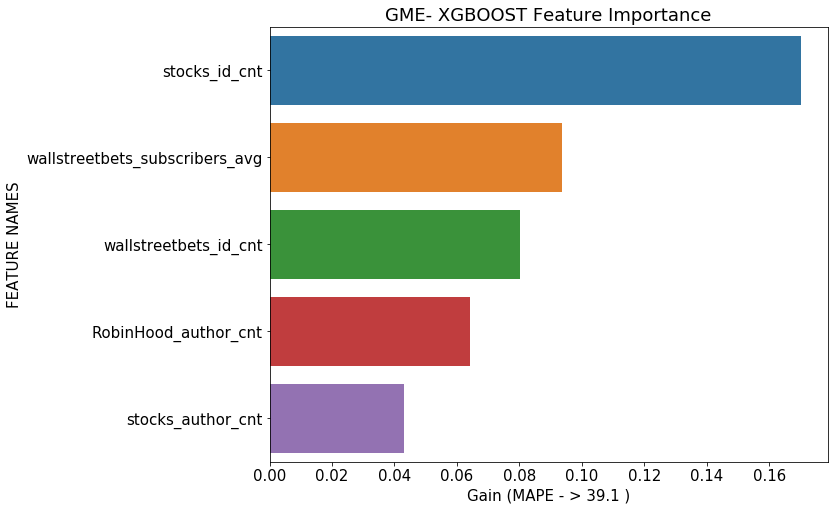

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.9s finished


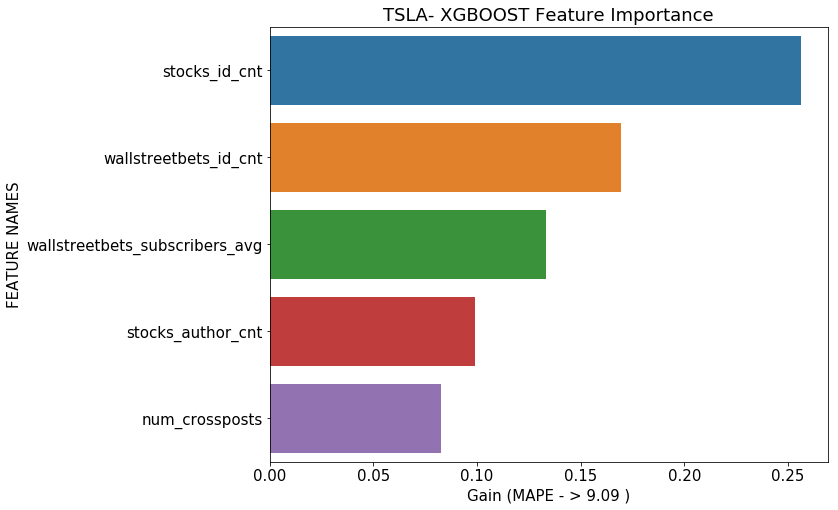

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    1.5s finished


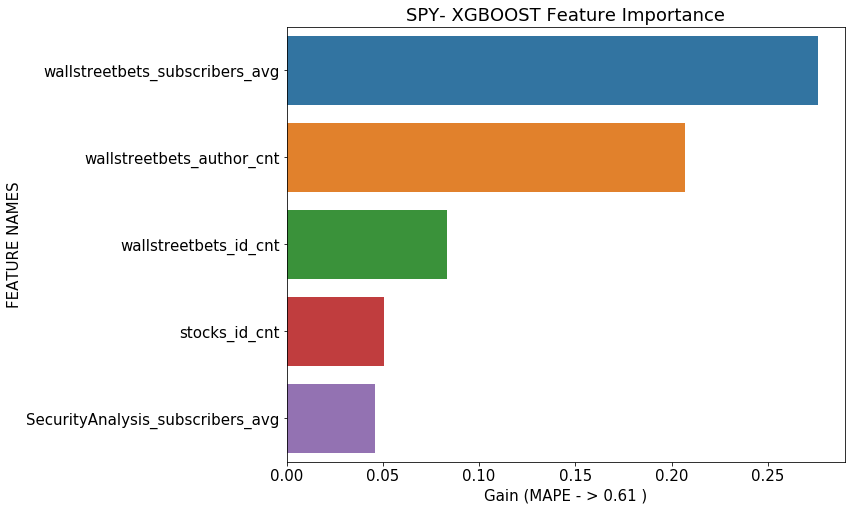

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.9s finished


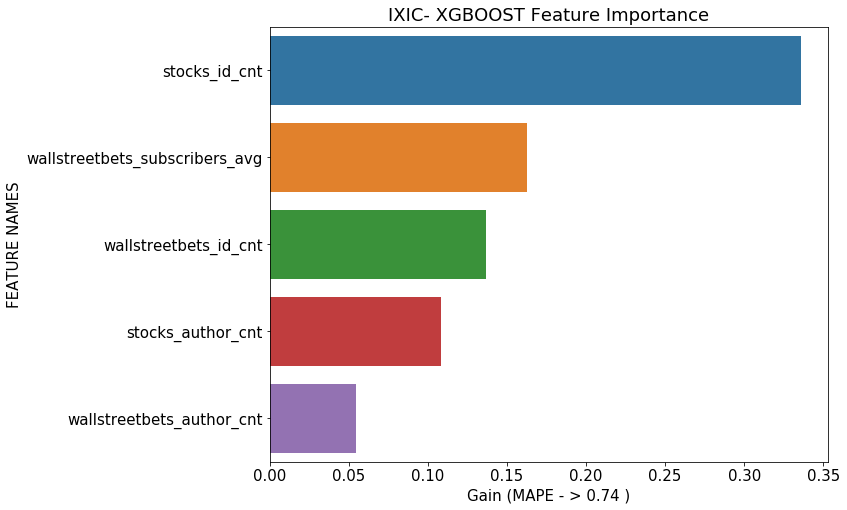

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.9s finished


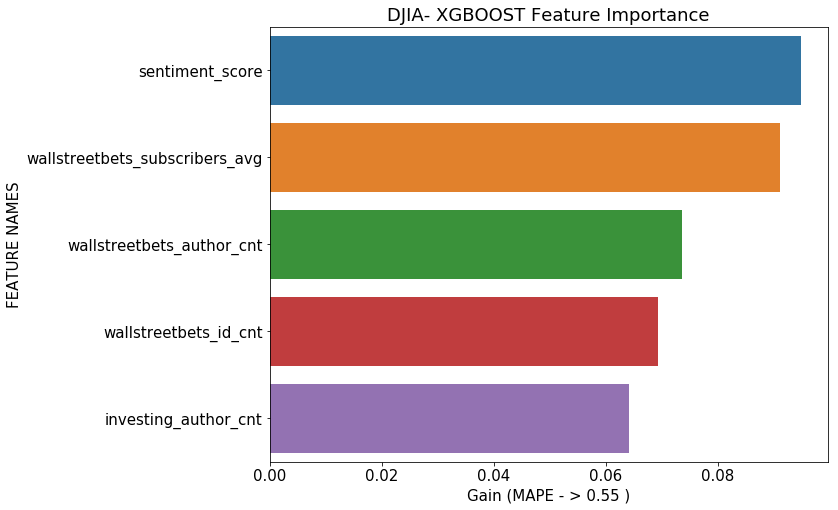

In [11]:
for i in tar:
    xgboost_model_func(com[train_col_wod],com[i],5,i,1)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    2.2s finished


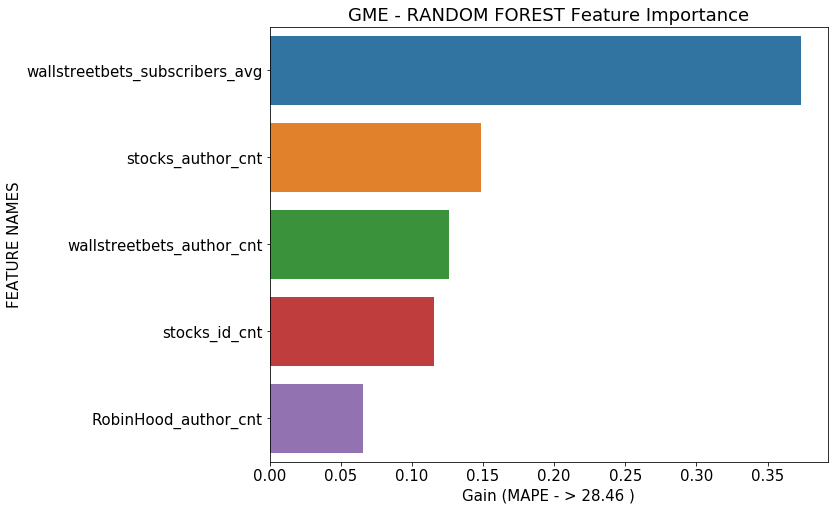

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    1.8s finished


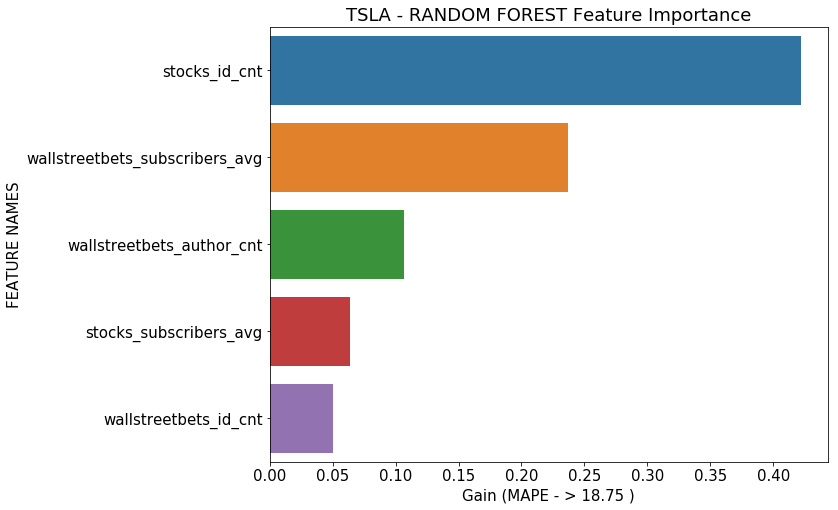

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    1.8s finished


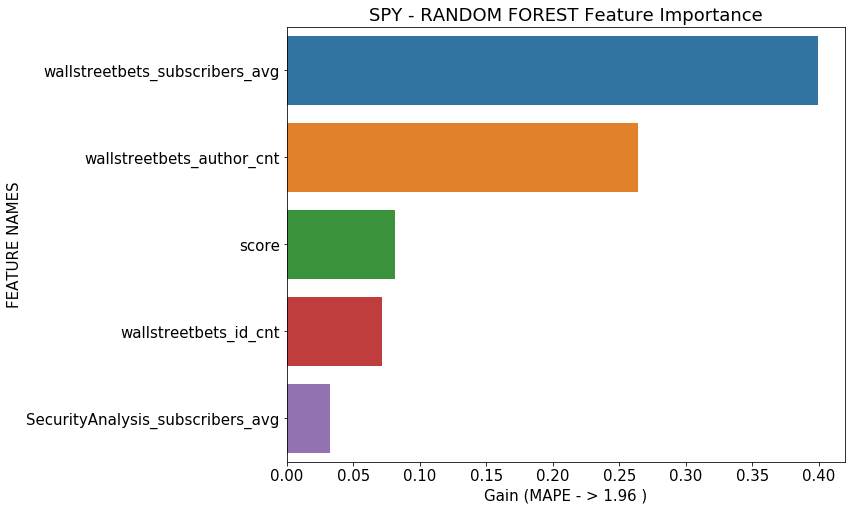

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    2.0s finished


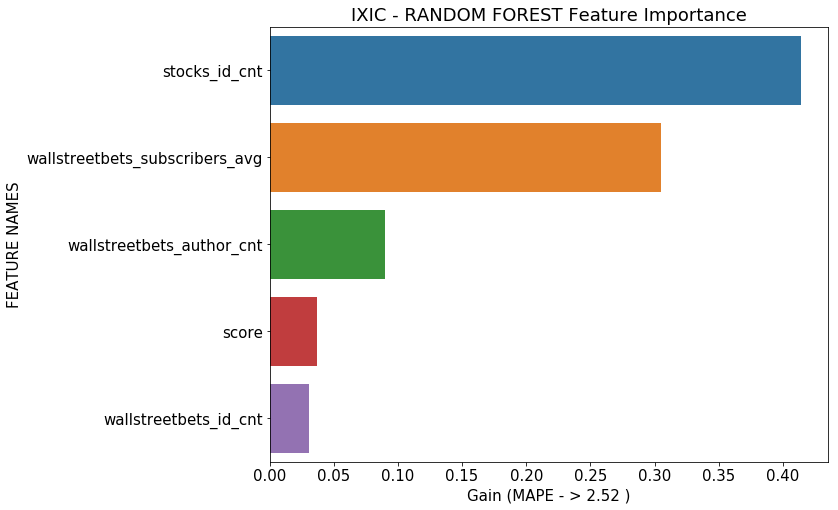

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    2.0s finished


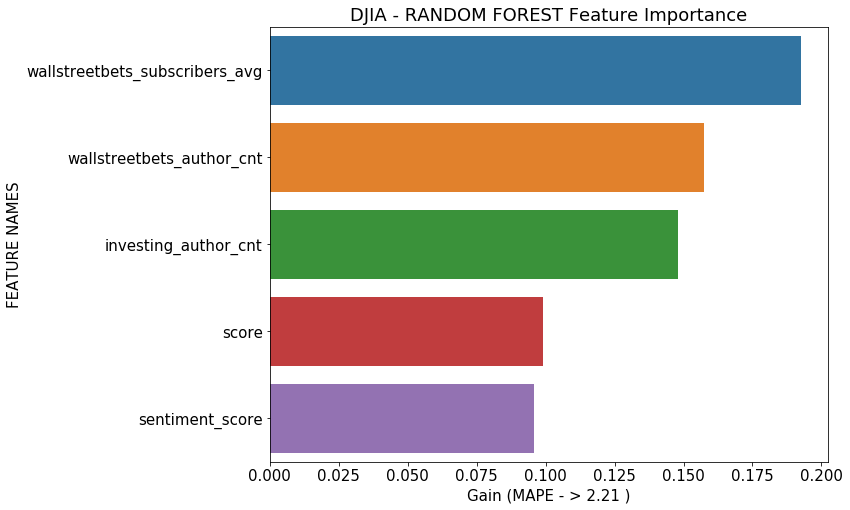

In [12]:
for i in tar:
    rf_model_func(com[train_col_wod],com[i],5,i,1)